In [1]:
from config.config import get_cfg
from model.rcnn import GeneralizedRCNN
import torch
import argparse

from data.build import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from data.utils import build_augmentation
from data.mapper import DatasetMapper
import data.transforms as T
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
import os
from layers.nms import batched_nms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

from structures.box import Boxes,pairwise_iou
from layers.wrappers import cat
from tools_det.memory import retry_if_cuda_oom
from model.sampling import subsample_labels

from model.ssl_score.preprocess import preprocess,open_candidate
from model.ssl_score.score import cosine_distance_torch

In [2]:
cfg = get_cfg()
cfg.merge_from_file('./config_files/voc.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20
cfg.MODEL.ROI_HEADS.USE_MLN = False
torch.cuda.set_device(2)
print(torch.cuda.current_device())

2


In [3]:
DIR_NAME = '/data/jeongeun/OWOD_datasets/VOC2007'
data = load_voc_instances(DIR_NAME,'test',VOC_CLASS_NAMES,phase=None,COCO_CLASS=True)[5000:]
print(len(data))
mapper = DatasetMapper(is_train=True, augmentations=build_augmentation(cfg,False))
data_loader = build_detection_test_loader(data,mapper=mapper,batch_size=1)
loader = iter(data_loader)

5246


In [ ]:
model = GeneralizedRCNN(cfg).to('cuda')
state_dict = torch.load('./ckpt/baseline/2_basebase_17500.pt')
model.load_state_dict(state_dict)
model.eval()

In [5]:
batched_inputs = next(loader)
images = model.preprocess_image(batched_inputs)
features = model.backbone(images.tensor)

features = [features['res4']]
anchors = model.proposal_generator.anchor_generator(features)
pred_objectness_logits, pred_anchor_deltas = model.proposal_generator.head(features)

# Transform
pred_objectness_logits = [
    # (N, A, Hi, Wi) -> (N, Hi, Wi, A) -> (N, Hi*Wi*A)
    score.permute(0, 2, 3, 1).flatten(1)
    for score in pred_objectness_logits
]
pred_anchor_deltas = [
    # (N, A*B, Hi, Wi) -> (N, A, B, Hi, Wi) -> (N, Hi, Wi, A, B) -> (N, Hi*Wi*A, B)
    x.view(x.shape[0], -1, model.proposal_generator.anchor_generator.box_dim, x.shape[-2], x.shape[-1])
    .permute(0, 3, 4, 1, 2)
    .flatten(1, -2)
    for x in pred_anchor_deltas
        ]

pred_proposals = model.proposal_generator._decode_proposals(
            anchors, pred_anchor_deltas)

In [6]:
proposal_box = pred_proposals[0][0]
proposal_score = pred_objectness_logits[0][0]
valid_mask = torch.isfinite(proposal_box).all(dim=1)
keep = batched_nms(proposal_box,proposal_score,valid_mask,0.3)
post_proposal_box = proposal_box[keep]
post_proposal_score = torch.sigmoid(proposal_score[keep])


torch.Size([40, 4])


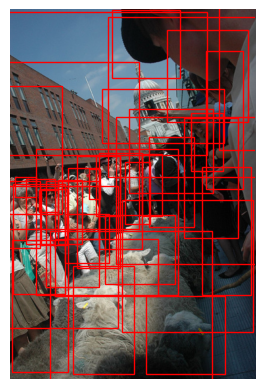

In [7]:
mask = (post_proposal_score>0.9)
top_box = post_proposal_box[mask]
print(top_box.shape)
image = batched_inputs[0]['image']
image = image.numpy().astype(np.uint8).transpose(1,2,0)

plt.figure()
ax = plt.gca()
demo_image = copy.deepcopy(image)
plt.imshow(demo_image)
for bbox in top_box:
    h = bbox[3] - bbox[1]
    w = bbox[2] - bbox[0]
    x = bbox[0] #+ w/2
    y = bbox[1] #+ h/2
    rect = patches.Rectangle((x,y),
                 w,
                 h,
                 linewidth=1,
                 edgecolor='red',
                 fill = False)
    ax.add_patch(rect)
plt.axis('off')
plt.show()

In [8]:
gt_instance = batched_inputs[0]['instances']
gt_boxes = gt_instance.gt_boxes
gt_labels = gt_instance.gt_classes
IoU = retry_if_cuda_oom(pairwise_iou)(gt_boxes.to('cuda'), Boxes(post_proposal_box))
matched_idxs, matched_labels = retry_if_cuda_oom(model.proposal_generator.anchor_matcher)(IoU)
label = gt_labels[matched_idxs]
pos_idx, neg_idx = subsample_labels(
            matched_labels, 32, 0.7, 0
        )

In [9]:
pos_gt_label = label[pos_idx]

unk_mask = (pos_gt_label==20)
unk_idx = pos_idx[unk_mask]

pos_mask = (pos_gt_label<20)
pos_idx = pos_idx[pos_mask]
positive_boxes = post_proposal_box[pos_idx].cpu().clamp(min = 0)
positive_scores = post_proposal_score[pos_idx].cpu()

unk_boxes = post_proposal_box[unk_idx].cpu().clamp(min = 0)
unk_scores = post_proposal_score[unk_idx].cpu()

neg_boxes = post_proposal_box[neg_idx].cpu().clamp(min = 0)
neg_scores = post_proposal_score[neg_idx].cpu()

In [10]:
device_vit = 'cuda:3'
referenec_set = open_candidate().to('cuda')
vit = torch.hub.load('facebookresearch/dino:main', 'dino_vits8').to(device_vit)


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


In [11]:
positive_patch = preprocess(batched_inputs[0]['image'],positive_boxes,None)
feat = vit(positive_patch.to(device_vit)).to('cuda')
pos_cos_sim = cosine_distance_torch(referenec_set,feat)
pos_total_score = positive_scores.to('cuda')*pos_cos_sim

unk_patch = preprocess(batched_inputs[0]['image'],unk_boxes,None)
feat = vit(unk_patch.to(device_vit)).to('cuda')
unk_cos_sim = cosine_distance_torch(referenec_set,feat)
unk_total_score =unk_scores.to('cuda')*unk_cos_sim

neg_patch = preprocess(batched_inputs[0]['image'],neg_boxes,None)
feat = vit(neg_patch.to(device_vit)).to('cuda')
neg_cos_sim = cosine_distance_torch(referenec_set,feat)
neg_total_score =neg_scores.to('cuda')*neg_cos_sim

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


tensor([0.5689, 0.0869, 0.4467, 0.3729, 0.0835, 0.4584, 0.4726, 0.3197, 0.4449,
        0.4444, 0.4625, 0.4475, 0.0123, 0.5042, 0.0073, 0.3515, 0.4478, 0.4472,
        0.4286], device='cuda:2', grad_fn=<MulBackward0>) tensor([0.0047, 0.0008, 0.0067], device='cuda:2', grad_fn=<MulBackward0>) tensor([1.5278e-06, 1.3205e-03, 8.8518e-07, 2.4096e-03, 2.2378e-03, 9.6154e-03,
        6.3053e-05, 2.7690e-03, 7.2172e-03, 3.0825e-03], device='cuda:2',
       grad_fn=<MulBackward0>)


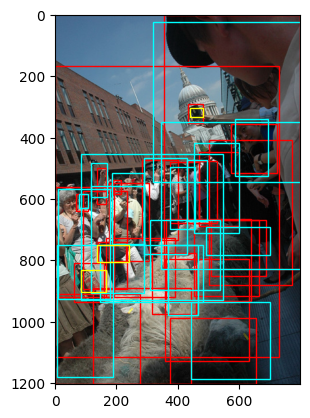

In [13]:
image = batched_inputs[0]['image']
image = image.numpy().astype(np.uint8).transpose(1,2,0)

plt.figure()
ax = plt.gca()
demo_image = copy.deepcopy(image)
plt.imshow(demo_image)
for bbox in gt_boxes:
    h = bbox[3] - bbox[1]
    w = bbox[2] - bbox[0]
    x = bbox[0] #+ w/2
    y = bbox[1] #+ h/2
    rect = patches.Rectangle((x,y),
                 w,
                 h,
                 linewidth=1,
                 edgecolor='red',
                 fill = False)
    ax.add_patch(rect)

for bbox in positive_boxes:
    h = bbox[3] - bbox[1]
    w = bbox[2] - bbox[0]
    x = bbox[0]
    y = bbox[1]
    rect = patches.Rectangle((x,y),
                 w,
                 h,
                 linewidth=1,
                 edgecolor='cyan',
                 fill = False)
    ax.add_patch(rect)

for bbox in unk_boxes:
    h = bbox[3] - bbox[1]
    w = bbox[2] - bbox[0]
    x = bbox[0]
    y = bbox[1]
    rect = patches.Rectangle((x,y),
                 w,
                 h,
                 linewidth=1,
                 edgecolor='yellow',
                 fill = False)
    ax.add_patch(rect)
plt.show()